In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-04_03-04_20180601_20191231_th70_per12_sm10.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

NQ       0.25
ES       0.25
YM       0.25
GC       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    27457.2
GC    12733.2
NQ    31633.4
YM    25885.0
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

97708.8

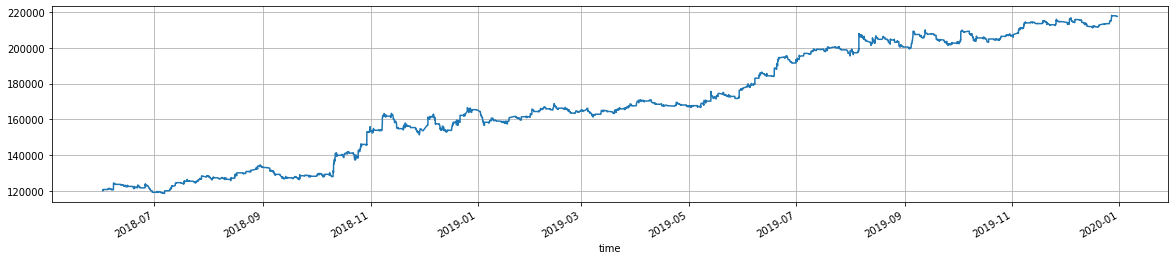

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     569
 GC    1041
 NQ    1996
 YM     601
 Name: action, dtype: int64,
 4207)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.381068
 GC    2.526699
 NQ    4.844660
 YM    1.458738
 Name: action, dtype: float64,
 10.21116504854369)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1194.90
GC    2519.22
NQ    4191.60
YM    1262.10
Name: commission, dtype: float64

In [15]:
df.commission.sum()

9167.820000000002

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.39,24.49,461.97,-257.94,1.79,22.82,520.0
NQ,0.40,31.70,448.42,-249.38,1.80,29.74,998.0
YM,0.40,86.28,761.05,-357.35,2.13,90.01,300.0
ES,0.44,96.68,840.86,-480.06,1.75,101.14,284.0
total,0.40,46.48,552.82,-296.59,1.86,43.17,2102.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.020508,0.252396,0.404971,0.728122
GC,0.020508,1.000000,0.023487,0.073396,0.367810
NQ,0.252396,0.023487,1.000000,0.248854,0.654176
YM,0.404971,0.073396,0.248854,1.000000,0.695161
total,0.728122,0.367810,0.654176,0.695161,1.000000


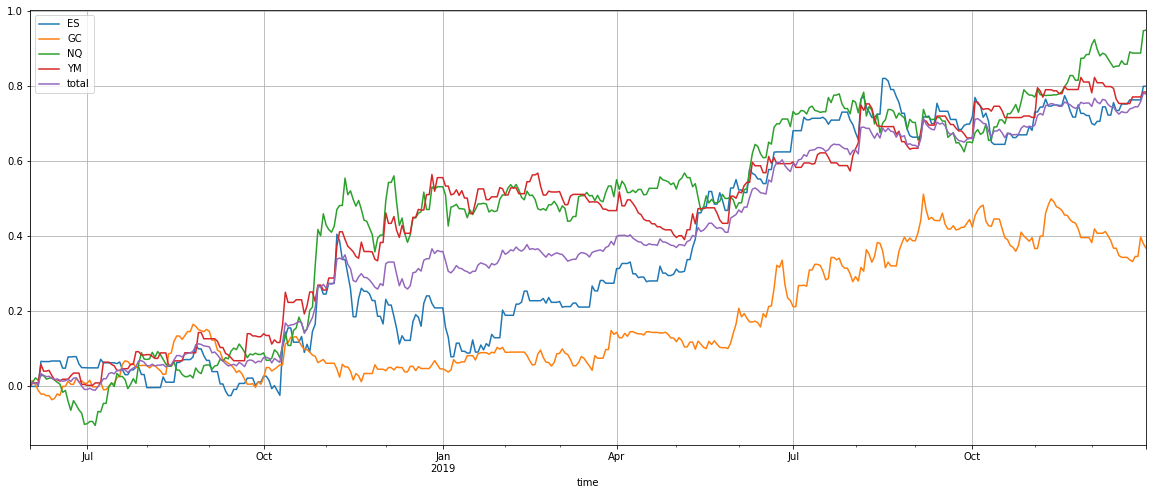

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

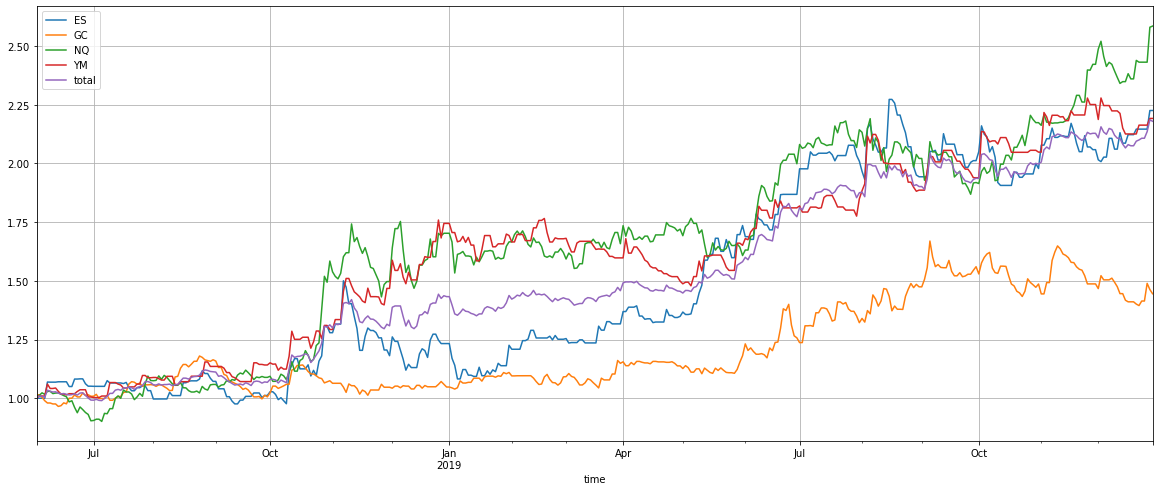

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.630962,0.252499,0.787396,0.615777,0.610397
Cumulative returns,1.224994,0.444969,1.584406,1.191226,1.179309
Annual volatility,0.380665,0.264151,0.359220,0.312816,0.207444
Sharpe ratio,1.470605,0.982805,1.795426,1.687100,2.400797
Calmar ratio,2.265269,1.534440,4.415363,3.792207,6.996204
Stability,0.881171,0.786349,0.888235,0.902443,0.963402
Max drawdown,-0.278537,-0.164555,-0.178331,-0.162380,-0.087247
Omega ratio,1.401366,1.208048,1.403081,1.496564,1.611929
Sortino ratio,2.894960,1.754706,3.106031,3.656459,5.081072
Skew,1.869085,1.109860,0.797826,2.052577,1.823135


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,5.13,0.85,-9.61,0.53,-0.79
2018-07-31,-1.81,4.90,18.99,8.15,7.51
2018-08-31,3.83,10.01,-1.56,4.43,4.32
2018-09-30,-5.60,-13.58,2.84,0.54,-4.04
2018-10-31,26.42,6.81,45.49,13.24,22.92
2018-11-30,-7.66,-2.56,-5.52,13.54,-0.31
2018-12-31,4.37,0.08,13.74,18.85,9.49
2019-01-31,-0.58,5.92,-2.15,-2.94,0.35
2019-02-28,2.08,-1.70,-2.71,-0.83,-0.69


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES       122.0
GC        44.0
NQ       158.0
YM       119.0
total    118.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-07 15:52:30,ES,SELL,2780.75,3458.3
2019-08-05 21:22:30,ES,BUY,2843.00,3408.3
2019-08-15 08:10:30,ES,BUY,2858.75,3295.8
2018-10-10 22:11:00,ES,BUY,2786.50,3245.8
2018-10-29 20:49:00,ES,BUY,2631.75,3195.8
...,...,...,...,...
2018-12-20 12:21:30,ES,BUY,2508.00,-1204.2
2018-11-15 19:24:30,ES,BUY,2718.25,-1291.7
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.2


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-08-05,0.113610,0.037011,0.035793,0.106360,0.073194
2018-11-07,0.140137,-0.015323,0.046107,0.089860,0.065195
2018-12-03,0.067777,-0.003989,0.095913,0.081860,0.060390
2018-10-29,0.106527,-0.016989,0.101773,0.044693,0.059001
2019-09-05,0.056527,0.073011,0.070387,0.030053,0.057494
...,...,...,...,...,...
2019-01-03,-0.025140,-0.004828,-0.079340,0.000000,-0.027327
2018-10-22,-0.041530,-0.009161,-0.021920,-0.037113,-0.027431
2018-12-10,-0.040280,-0.001656,-0.058840,-0.018420,-0.029799
